ЗАДАНИЕ НУЖНО ДЕЛАТЬ НА T4! Если делаете на kaggle, то 2xT4

Для выполнения вам нужно сделать копию этого ноутбука и далее выполнять задание, после выполнения закинуть ссылку на Свой ноутбук в лмс

Не забывайте указывать вариант, а так же открывать ноутбук для чтения в колабе

**Базовый вариант:**

В этом домашнем задании вы должны будете расписать код и ниже сделать текстовую ячейку как он работает

Нужно так же сделать 2 диаграммы моделей GAN (Сам генератор и дискриминатор) это написано над кодом модели

**Продвинутый вариант:**

Здесь вам понадобится сделать свою модель и поиграться с ней (можно использовать этот же датасет или другой). Рекомендуется делать на kaggle, но нужа будет подписка, если есть желание получить ее, то в интернете есть много решений

In [ ]:
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
import kagglehub
dataroot = kagglehub.dataset_download("splcher/animefacedataset")
Image_Size = 64
batch_size = 128
lr = 0.0002
num_epochs=100
ngpu = 2


100%|██████████| 395M/395M [00:04<00:00, 97.3MB/s]


Extracting files...


In [ ]:

dataset = ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(Image_Size),
                               transforms.CenterCrop(Image_Size), # приведение изображений в размер Image_Size х Image_Size
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # приведение значений в [-1, 1]
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=8).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

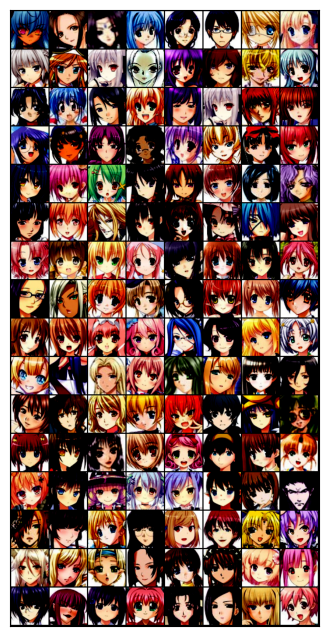

In [ ]:
show_batch(dataloader)

## Generator

Генератор соответствует архитектуре DCGAN, принимает на вход латентное пространство [100, 1, 1] (noise, инициализировано в секции Training) и с помощью обратной свертки (TConv слоёв) на выходе выдает тензор [3, 64, 64] значений от -1 до 1 (RGB изображение 64*64)

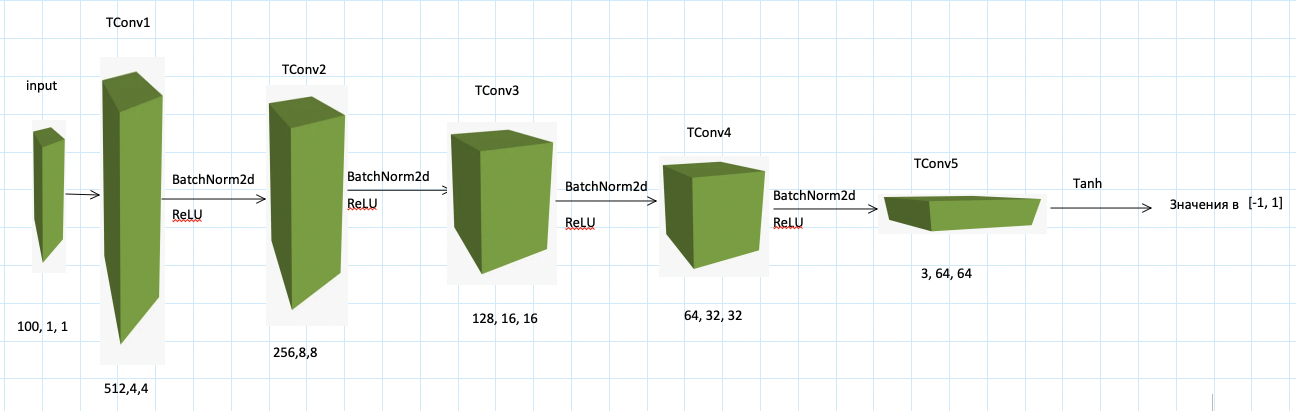

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
print(torch.cuda.device_count())

1


In [ ]:
ngpu = torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

print(netG)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Discriminator

Дискриминатор принимает на вход RGB изображения 64х64 и определяет реальное ли оно (на выходе вероятность от 0 до 1). В качестве функции активаци используется LeakyReLU для повышенной чувствительности

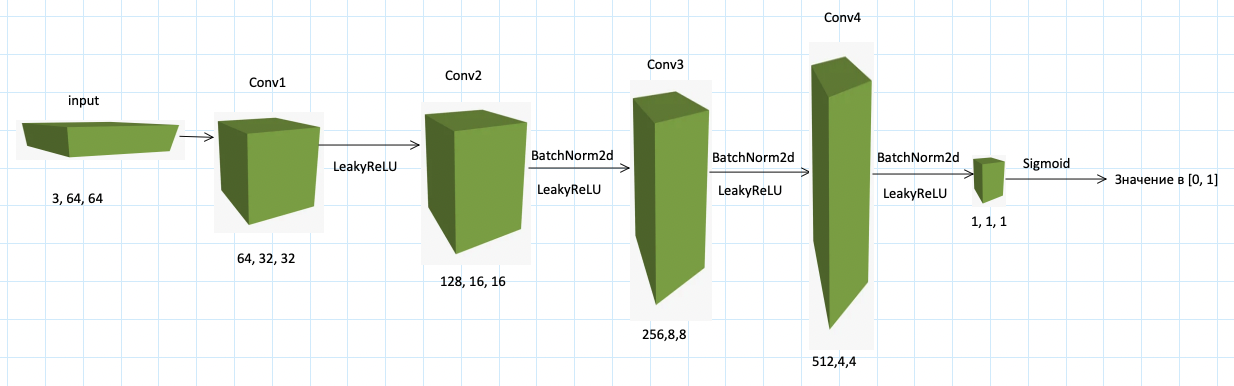

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Loss Functions and Optimizers

In [ ]:
criterion = nn.BCELoss()  # фенункция - бинарная кросс-энтропия для классификации

fixed_noise = torch.randn(64, 100, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr)  # для генератора и дискриминатора используем оптимизотор adam с заданным в начале значением lr

## Training

In [ ]:

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):  # основной цикл обчения (по эпохам и по батчам)

        # обучение дискриминатора
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, 100, 1, 1, device=device) # генерация латентного пространства
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # обучение генератора
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/100][0/497]	Loss_D: 1.5193	Loss_G: 2.5077	D(x): 0.5033	D(G(z)): 0.5514 / 0.0858
[0/100][50/497]	Loss_D: 0.0145	Loss_G: 9.2861	D(x): 0.9977	D(G(z)): 0.0120 / 0.0001
[0/100][100/497]	Loss_D: 0.0158	Loss_G: 10.4798	D(x): 0.9908	D(G(z)): 0.0052 / 0.0000
[0/100][150/497]	Loss_D: 0.0067	Loss_G: 11.9748	D(x): 0.9943	D(G(z)): 0.0007 / 0.0000
[0/100][200/497]	Loss_D: 0.0051	Loss_G: 10.9694	D(x): 0.9989	D(G(z)): 0.0040 / 0.0000
[0/100][250/497]	Loss_D: 0.0018	Loss_G: 13.2534	D(x): 0.9983	D(G(z)): 0.0001 / 0.0000
[0/100][300/497]	Loss_D: 0.0200	Loss_G: 16.3820	D(x): 0.9858	D(G(z)): 0.0001 / 0.0000
[0/100][350/497]	Loss_D: 0.0678	Loss_G: 8.2500	D(x): 0.9743	D(G(z)): 0.0063 / 0.0010
[0/100][400/497]	Loss_D: 0.0000	Loss_G: 21.5654	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/100][450/497]	Loss_D: 0.0194	Loss_G: 10.6874	D(x): 0.9989	D(G(z)): 0.0171 / 0.0001
[1/100][0/497]	Loss_D: 0.0206	Loss_G: 10.2614	D(x): 0.9859	D(G(z)): 0.0015 / 0.0001
[1/100][50/497]	Loss_D: 0.0034	Loss_

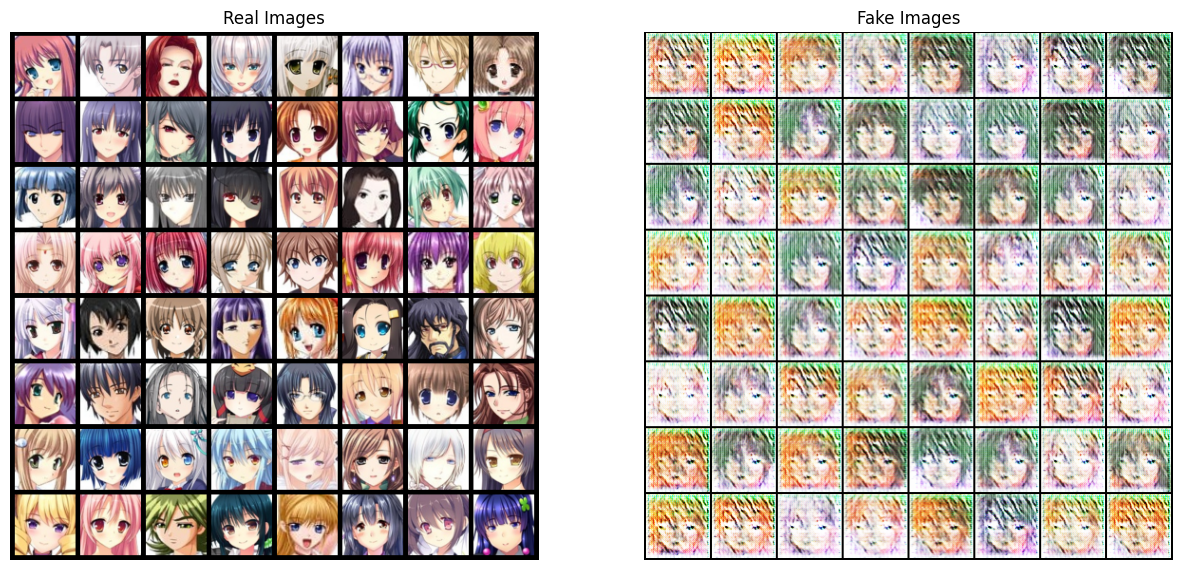

In [ ]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

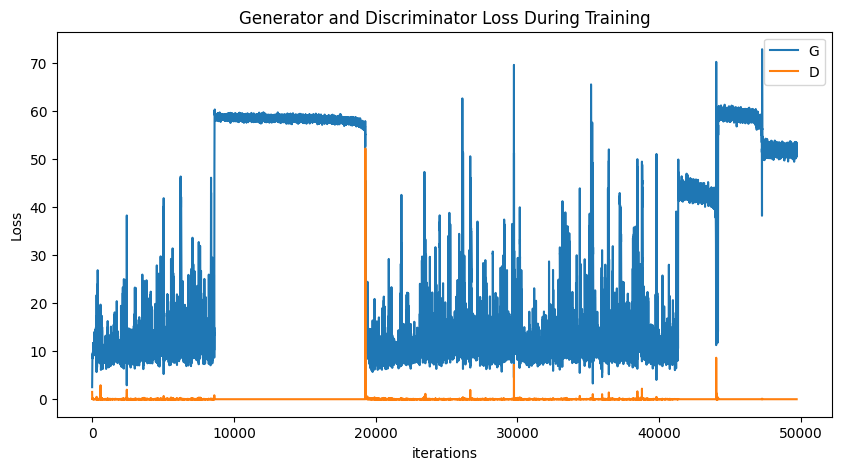

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())